In [1]:
# Installations
# pip install -q -U google-generativeai
# pip install pandas
# pip install seaborn
# pip install nltk
# pip install scikit-learn

In [2]:
# Importing Dependencies
import google.generativeai as genai
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import traceback
import nltk
from PIL import Image
import time

start = time.time()

/Users/bhavishyapandit/VSCProjects/google-ai-hackathon24/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# User input: Getting table description
# table_description = input('Table/Data description')
table_description = 'Data consists of customer level info about different Hotels along with their customer reviews and ratings.'

### Reading Data

In [4]:
# Fetching credentials
f = open('credentials.json', 'r')
creds = json.load(f)
gemini_token = creds['gemini_api']

# Reading data
# urls = ['https://drive.google.com/file/d/1Fl8kBzjXvDTcbr0DaUEjdf4lqUfRnK2Z/view?usp=sharing', 'https://drive.google.com/file/d/19jHTwx1iaN5MUftPCltXnna9cJI8C3uU/view?usp=sharing',
#         'https://drive.google.com/file/d/1_LWBLQX0EbR1i9Xgbe8RlTRR5Bk6DgtN/view?usp=sharing']

# df = pd.DataFrame()
# for url in urls[:1]:
#     url='https://drive.google.com/uc?id=' + url.split('/')[-2]
#     df = pd.concat([df, pd.read_csv(url, low_memory=False)])

df = pd.read_csv('data/hotels_rating/Datafiniti_Hotel_Reviews.csv')
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(10000, 25)


,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


In [5]:
def generate_response(prompt, temperature):
    generation_config = {
      "temperature": temperature,
      "top_p": 1,
      "top_k": 1,
    #   "max_output_tokens": max_tokens,
    }
    safety_settings = [
        {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_MEDIUM_AND_ABOVE"
        },
        {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_MEDIUM_AND_ABOVE"
        },
        {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_MEDIUM_AND_ABOVE"
        },
        {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_MEDIUM_AND_ABOVE"
        },
    ]
    genai.configure(api_key=gemini_token)
    model = genai.GenerativeModel('gemini-pro')
    model = genai.GenerativeModel(model_name="gemini-1.0-pro",
                                    generation_config=generation_config,
                                    safety_settings=safety_settings)
    convo = model.start_chat(history=[])
    convo.send_message(prompt)
    return re.sub(r"\*\*([^*]+)\*\*", r"\1", convo.last.text)

### Creating Data Dictionary

In [6]:
data_dict = {}
create_data_dict = f'''Table description: {table_description}
Columns: {df.columns}
Data (First 5 columns): {df.dtypes}

Instruction:
1. Based on the above mentioned details create a data dictionary which a small description of table, each column and the data type of each column.
2. Don't generate anything else. Be concrete and concise in your response
3. Give the output in the expected format of a dictionary only!
'''
output = '''
Expected Output -> 
data_dict={
'tbl_description': 'description of table', 
'columns': {
            'Name of the column 1': {'col_description':'description of column 1', 'data_type':'Data Type of the column 1'},
            'Name of the column 2': {'col_description':'description of column 2', 'data_type':'Data Type of the column 2'},
            'Name of the column 3': {'col_description':'description of column 3', 'data_type':'Data Type of the column 3'}
        }
}'''

create_data_dict+=output

response = generate_response(create_data_dict, 0)
print(response)
exec(response)

data_dict={
'tbl_description': 'Data consists of customer level info about different Hotels along with their customer reviews and ratings.', 
'columns': {
            'id': {'col_description':'Unique identifier for each row', 'data_type':'object'},
            'dateAdded': {'col_description':'Date when the row was added', 'data_type':'object'},
            'dateUpdated': {'col_description':'Date when the row was last updated', 'data_type':'object'},
            'address': {'col_description':'Address of the hotel', 'data_type':'object'},
            'categories': {'col_description':'Categories associated with the hotel', 'data_type':'object'},
            'primaryCategories': {'col_description':'Primary categories associated with the hotel', 'data_type':'object'},
            'city': {'col_description':'City where the hotel is located', 'data_type':'object'},
            'country': {'col_description':'Country where the hotel is located', 'data_type':'object'},
            'keys': {'col_

### Intent Identification (Analysis)

In [7]:
# # If user want's suggestions of different types of analysis
# prompt = f'''{table_description}\n Refer {data_dict['columns'].keys()} and tell me the different analysis that can be done from the available columns keeping the given use case in mind.
# Focus on Exploratory Data Analysis only. 

# Unique values in categorical column: {df.select_dtypes(include='object').nunique()}
# Unique values in numerical column: {df.select_dtypes(include='number').nunique()}

# Instructions:
# 1. Keep your response consise and concrete
# 2. Give your suggestions in bullet points
# 3. Mention the columns that will help in the completion of the respective analysis
# 4. Make the analysis rich by including as many important columns as possible. Don't include columns with no/very little variance.
# 5. Every new type of analysis in the response should be represented with ">>" at all costs
# 6. The analysis should be complex but at the same time either convey action items or actionable insights
# 7. Don't generate a column name by your own. Use only the columns: {data_dict['columns'].keys()}
# 8. Don't mention the columns in "" or ''.
# 9. Don't add anything else to your response, except for Analysis name and the relevant columns
# 10. Give the response in the expected format only.
# 11. The analysis should be suggested from the growth/impact to the business - perspective


# Expected output:
# >> Analysis 1
# - Columns: A, B, C etc.

# >> Analysis 2
# - Columns: A, C, E etc.
# etc.
# '''

# types_of_analysis = generate_response(prompt, 0.5)
# print(types_of_analysis)

In [8]:
# # User selects an analysis to perform
# list_of_analyses = types_of_analysis.split('>> ')[1:]
# my_analysis = list_of_analyses[0]
# my_analysis = my_analysis.replace('\n','')
# my_analysis

In [9]:
# If user wants to give his own analysis
my_analysis = 'Tell me the name of top 3 hotels by average rating from each city'
identify_colums = f'''Analysis: {my_analysis}
Remember: Almmost every analysis requires some kind of aggregation or grouping.

Instructions:
1. Based on the Analysis mentioned, Give the names of the relevant columns from {data_dict['columns'].keys()}
2. Don't generate any column of your own
3. Give the names of all the relevant columns that exist
4. If the analysis request is not direct then identify a logic from the given columns that would help you with the analysis.
5. Don't write anything else, just the column names.

Expected Output if relevant columns found:
Columns: A, C, E etc.
'''

column_names = generate_response(identify_colums, 0)
print(column_names)

Columns: city, name, reviews.rating


In [10]:
# columns to work on
# Find the index of "Columns:"
columns_index = column_names.find("Columns:")

# Extract the text after "Columns:"
columns_text = column_names[columns_index + len("Columns:"):].strip()

# Print the extracted text
columns = columns_text.split(', ')
columns

['city', 'name', 'reviews.rating']

### Preprocessing Data

In [11]:
preprocessing_template = '''
> Data Cleaning:-

    When to use: Should be performed whenever the dataset contains missing values. This applies to both numerical and textual data.
    For what type of data: This step is applicable to all types of data, including numerical, categorical, and textual data.
    
    Actions:
    Drop columns with a high proportion of missing values if those columns are not critical for analysis. If missing values > 25% then drop the column.
    Impute missing values for columns with relatively few missing values, especially if dropping the entire column would result in loss of important information.
    Remove irrelevant information from text data, such as stop words or punctuation marks.

> Data Imputation:-

    When to use: Data imputation is used to fill in missing values (e.g. Null, None or NaN) in the dataset. Impute mode for categorical and mean/median otherwise.
    For what type of data: This step is applicable to numerical and categorical data. Text data cleaning techniques can sometimes address missing values, but imputation might be necessary in specific cases.

> Feature Scaling:-

    When to use: Feature scaling is can be done when the features in the dataset have different scales. 
    But you must not scale columns/features that are ordinal (representing order) in nature like rank, ratings etc at any cost!
    For what type of data: This step is primarily applicable to numerical data, but it can also be used for some types of categorical data.

> Text Preprocessing:-

    When to use: Text preprocessing involves cleaning and transforming textual data into a format suitable for analysis or model training.
    For what type of data: This step is specific to textual data, such as natural language text.

    Actions:
    Lowercase all text.
    Remove punctuation marks.
    Apply stemming or lemmatization to reduce words to their root form (if applicable)

> Outlier Removal:-

    When to use: Outliers are data points that significantly differ from other observations in the dataset. Outliers can negatively impact the performance of machine learning models by skewing the results or increasing model variance.
    For what type of data: This step is applicable to numerical data, but it can also be used for some types of categorical data (e.g., identifying rare categories).

> Noise Reduction:-

    When to use: Noise in the data can arise from various sources, such as measurement errors or data collection processes. Noise reduction techniques aim to remove or minimize the impact of noise on the dataset.
    For what type of data: This step is applicable to numerical data, textual data, and categorical data.

    Actions:
    For numerical data, apply smoothing techniques such as moving averages or median filters.
    For text data, techniques like spell checking, stemming, or lemmatization can reduce noise.
    For categorical data, grouping rare categories or merging similar categories can reduce noise.

> Feature Engineering:-

    When to use: Feature engineering involves creating new features from existing ones or transforming existing features to improve the performance of machine learning models. For E.g. If a feature like date is involved and if the data is on a daily basis - aggregate it to weekly or monthly basis for better analysis unless not a stock price data.
    For what type of data: This step is applicable to all types of data.

    Actions:
    Generate new features by combining existing ones, extracting useful information from text or categorical variables, or creating interaction terms.
    Transform features using mathematical functions such as logarithms, square roots, or polynomial transformations to better capture non-linear relationships.
    Apply techniques specific to text data, such as TF-IDF (Term Frequency-Inverse Document Frequency) to weight the importance of words.

> Data Normalization or Standardization:-

    When to use: Normalization or standardization can be applied to scale numerical data to a standard range or distribution if required by the specific model being used. 
    You shouldn't do it to columns that are ordinal in nature like rank, rating etc, educational level etc.
    For what type of data: This step is applicable to numerical data and is optional depending on the model's requirements.

    Actions:
    Scale numerical features to a specific range (e.g., [0, 1]) using min-max scaling or standardize features to have a mean of 0 and standard deviation of 1 using z-score normalization.

> '''

pattern = r'> (.*?):-'
preprocessing_steps = re.findall(pattern, preprocessing_template)
prep_details = preprocessing_template.split('>')[1:-1]

# Print the extracted text
print(preprocessing_steps)

['Data Cleaning', 'Data Imputation', 'Feature Scaling', 'Text Preprocessing', 'Outlier Removal', 'Noise Reduction', 'Feature Engineering', 'Data Normalization or Standardization']


In [12]:
data = df[columns]
data.head()

,city,name,reviews.rating
0,Rancho Santa Fe,Rancho Valencia Resort Spa,5.0
1,Rancho Santa Fe,Rancho Valencia Resort Spa,5.0
2,Rancho Santa Fe,Rancho Valencia Resort Spa,5.0
3,Hanover,Aloft Arundel Mills,2.0
4,Hanover,Aloft Arundel Mills,5.0


In [13]:
columns_intel = ''
for key, val in data_dict['columns'].items():
    if key in columns:
        columns_intel+=f'{key}: {val}\n'

print(columns_intel)

city: {'col_description': 'City where the hotel is located', 'data_type': 'object'}
name: {'col_description': 'Name of the hotel', 'data_type': 'object'}
reviews.rating: {'col_description': 'Rating of the review', 'data_type': 'float64'}



In [14]:
# Checking preprocessing steps
preprocessing_dict = {}
for idx, step in enumerate(tqdm(preprocessing_steps)):
    step_to_take = f'''
    Details -
    Analysis to perform: "{my_analysis}"
    Based on the analysis identify if preprocessing "{step}" is required or not. 
    Columns: {columns_intel}
    Data dypes: {data.dtypes}
    Description of data: {data.describe()}
    Preprocessing Details: {prep_details[idx]}
    Remember: Almost all the type of analysis include aggregation/grouping of data. Based on that identify whether {step} preprocessing step is necessary or not.


    Adhere to below instructions at all costs!
    Instructions -
    0. Consider the details shared above to make the rules for your preprocessing test if needed
    1. Assume the dataframe "data" exists already
    2. Do not read data from anywhere
    3. Write simple code that's easy to understand without any errors in the code
    4. Write a function that performs the preprocessing test and returns the response of the function in 'True' or 'False'
    5. Write only the code, don't include any other text. The code shouldn't have any error be it syntactical or logical
    6. Install and Import whatever package is necessary
    7. Keep the original dataframe intact. Don't overwrite it - at any cost
    8. If preprocessing step is not applicable for the data mentioned then return 'False'

    Expected Output:
    def preprocessing_test(data):
        # Preprocessing logic

        return True or False based on the logic
    result = preprocessing_test(data)
    '''
    count = 0

    # Automated debugging
    while count<3:
        try:
                if count==0:
                    test_of_step = generate_response(step_to_take, 0)
                test_of_step = test_of_step.replace('`', '')
                result = ''
                exec(test_of_step)
                preprocessing_dict[step] = result
                break
            
        except Exception as e:
            error_message = f'''
            Code:
            {test_of_step}
            Traceback of the code: {traceback.format_exc()}

            Adhere to below instructions at all costs!
            Instruction:
            1. Identify the cause of the error and rewrite the code - make it error free
            2. Don't include any text in your response
            3. Rewrite the code as a function
            4. Follow these instructions by all means
            '''

            test_of_step = generate_response(test_of_step, 0.2)
            test_of_step = test_of_step.replace('python', '')
            test_of_step = test_of_step.replace('`', '')
            count+=1

preprocessing_dict

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [01:29<02:25, 29.18s/it]

False


 50%|█████     | 4/8 [01:52<01:47, 26.92s/it]

False


 62%|██████▎   | 5/8 [02:13<01:14, 24.80s/it]

city              False
name              False
reviews.rating    False
dtype: bool


 75%|███████▌  | 6/8 [02:40<00:51, 25.54s/it]

False


100%|██████████| 8/8 [03:45<00:00, 28.21s/it]


{'Feature Scaling': False,
 'Text Preprocessing': False,
 'Outlier Removal': city              False
 name              False
 reviews.rating    False
 dtype: bool,
 'Noise Reduction': False}

In [15]:
# Performing only those preprocessing steps that are required

# to know how was preprocessing done - code_transcript
code_transcript = ''

for key, val in tqdm(preprocessing_dict.items()):
    if val==True:
        write_code_for_prep_step = f'''
        Details -
            Analysis to perform: {my_analysis}
            Preprocessing step: {key}
            Preprocessing Details: {re.findall(rf'> {key}:-(.*?)>', preprocessing_template, re.DOTALL)[0]}
            Columns: {columns_intel}
            Description of data: {data.describe()}
            Data types of columns: {data.dtypes}
        
        Adhere to below instructions at all costs!
        Instructions -
        0. Consider the details shared above for rules of your preprocessing test if required
        1. Assume the dataframe "data" exists already
        2. Do not read or generate data by yourself
        3. Do not mention python language in your response
        4. Write simple code that's easy to understand without any errors
        5. Write a function that performs the preprocessing and return the dataframe after preprocessing it
        6. Only write the code don't include any other text. The code shouldn't have any error be syntactical or logical
        7. Call the function. Make sure you don't return an empty dataframe.
        8. Don't use lambda function to write your code at any cost!
        9. From the function name it should be understandable which preprocessing technique was used.
        '''
        count = 0

        # Automated debugging
        while count<3:
            try:
                if count==0:
                    prep_code_output = generate_response(write_code_for_prep_step, 0.1)
                if count!=0:
                    pass
                prep_code_output = prep_code_output.replace('`','')
                exec(prep_code_output)
                break
            
            except Exception as e:
                error_message = f'''
                Code:
                {write_code_for_prep_step}
                Traceback of the code: {traceback.format_exc()}

                Adhere to below instructions at all costs!
                Instruction:
                1. Identify the cause of the error and rewrite the code - make it error free
                2. Don't include any text in your response
                3. Rewrite the code as a function
                4. Follow these instructions by all means
                '''

                write_code_for_prep_step = generate_response(write_code_for_prep_step, 0.2)
                write_code_for_prep_step = write_code_for_prep_step.replace('python', '')
                write_code_for_prep_step = write_code_for_prep_step.replace('`', '')
                count+=1
        
        code_transcript+=prep_code_output+'\n-----------------------------------------\n'

 50%|█████     | 2/4 [00:00<00:00, 9799.78it/s]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
print(my_analysis)
data.head()

Give me the name of top 5 cities with the highest number of hotels


,city,population,hotel_count
0,London,1.433640,1
1,Paris,-0.621941,1
2,New York,1.379883,1
3,Tokyo,1.448136,1
4,Berlin,-0.140723,1


In [ ]:
# Perform analysis - 
print(my_analysis)
write_code_for_analysis = ''
count = 0
while count<3:
    try:
        query = f'''
        Task: {my_analysis}
        Remember: Analysis is always some type of aggregation or group of certain columns to get the desired result.

        Instructions:
        1. Write code in python to only execute the task.
        2. Assume a dataframe with the name "data" already exists.
        3. Dataframe df has the following columns: {data.columns}. Use the column names for your refernece while generating the code.
        4. Don't include the code to read the file. Write the code assuming the dataframe is already exists.
        5. Don't generate your own data. 
        6. First 10 rows of the dataframe you will work on: {data.head(10)}
        7. Dataframe should have {data.columns} as its columns only.
        8. Don't write code to train any machine learning model. Write code only to analyse the data. 
        9. Save the output of the analysis a txt file: analysis_result.csv

        For your reference - these were steps that were taken to preprocess the data: {code_transcript}
        Important: If columns have been encoded then decode them.
        '''
        if count==0:
            write_code_for_analysis = generate_response(query, 0)
        write_code_for_analysis = write_code_for_analysis.replace('python', '')
        write_code_for_analysis = write_code_for_analysis.replace('`','')
        exec(write_code_for_analysis)
        break
    except Exception as e:
        error_message = f'''
            Code:
            {write_code_for_analysis}
            Traceback of the code: {traceback.format_exc()}

            Adhere to below instructions at all costs!
            Instruction:
            1. Identify the cause of the error and rewrite the code - make it error free
            2. Don't include any text in your response
            3. Rewrite the code as a function
            4. Follow these instructions by all means
            '''

        write_code_for_analysis = generate_response(error_message, 0.5)
        count+=1
        
    code_transcript+=write_code_for_analysis+'\n-----------------------------------------\n'

Give me the name of top 5 cities with the highest number of hotels


In [ ]:
analysis_output = open('analysis_result.csv').read()
insight_prompt = f'''
Based on the Analysis Output shared below, tell what would be best way to represent the insights of the given analysis - Visualization or Text
1. Choose Visualization when the number of fields are less and thus the chart formed would be readable to user.
2. Choose Text when the number of values are more or the output length is long.

Expected Output: Visualization or Text
Analysis wanted: {my_analysis}
Analysis Output: {analysis_output}
'''

insight_choice = generate_response(insight_prompt, 0)
insight_choice

'Visualization'

 1. The visualization is a bar chart.
2. The bar chart shows the top 5 cities with the highest number of hotels.
3. The cities are London, Paris, New York, Tokyo, and Berlin.
4. All the cities have the same number of hotels, i.e., 1.


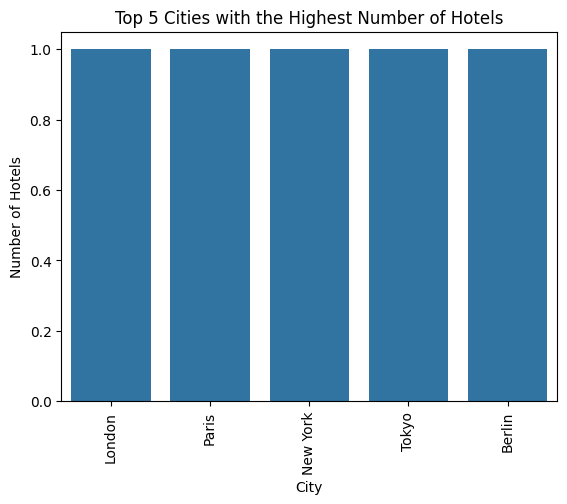

In [ ]:
def generate_response_gemini_image(prompt, img):
        response = model_cv.generate_content([prompt, img], stream=True)
        response.resolve()
        return response.text

def understand_image(img):
    prompt = f'''
    Analysis: {my_analysis}
    Output: {analysis_output}
    Data: {data.columns}

    The given image is extracted from jupyter notebook of the analysis. It is a type of visualisation. 
    If visualization: 
        1. Identify the type of visualization
        2. If labels or legends are present then using them, extract important and accurate insights with numerical figures or percentages from the visualization if there are any.
        3. The insights should be accurate and actionable.
    
    Instructions:
    1. Make sure above conditions are met.
    2. Do not include anything else in your response.
    3. Be concise, crisp and concrete.
    '''
    return generate_response_gemini_image(prompt, img)


if insight_choice=='Visualization':
    count = 0
    while count<3:
        try:
            visualization_prompt = f'''
            Information - 
            Task: {my_analysis}
            Output: {analysis_output}

            Types of charts:
            1. Line Chart: Good for trends over time/categories, bad for many data points or complex relationships.
            2. Bar Chart: Compares categories/frequencies, avoid for many categories or negative values.
            3. Scatter Plot: Explores relationships between two variables, not ideal for more than 3 variables or unclear patterns.
            4. Pie Chart: Shows proportions of a whole, avoid for many categories or unclear comparisons.
            5. Histogram: Visualizes distribution of continuous data, not for categorical data.
            6. Box Plot: Compares distributions across categories, avoid if outliers dominate.
            7. Heatmap: Good for visualizing relationships between many variables, bad for complex data, overwhelming for large datasets
            8. Word clouds: good for visual exploration of frequent terms in text data, bad for in-depth analysis.

            Follow the instructions by all means.
            Instructions -
            0. Based on the information available above identify which type of chart would suit the best to convey the insights.
            1. Write code in python to perform an insightful visualization from the output shared above. Don't write any other text. Just code.
            2. Make a new dataframe which has the following data: {analysis_output} and columns: {data.columns} from 'analysis_result.csv'
            3. Don't generate your own data.
            4. Visualization should have title, axis labels, legend etc.
            5. Save the visualization with the name 'viz.png'
            6. Always show x axis labels with a rotation of 90 degrees
            7. If the chart can be built using Seaborn or Plotly then use it all costs
            8. If the column/feature has been encoded then from {code_transcript} extract the origial values of the encoded column to show in the visualization.
            '''
            if count==0:
                vis_code = generate_response(visualization_prompt, 0.1)
            vis_code = vis_code.replace('python', '')
            vis_code = vis_code.replace('`', '')
            exec(vis_code)
            break
        except Exception as e:
            error_message = f'''
                Code:
                {vis_code}
                Traceback of the code: {traceback.format_exc()}

                Adhere to below instructions at all costs!
                Instruction:
                1. Identify the cause of the error and rewrite the code - make it error free
                2. Don't include any text in your response
                3. Rewrite the code as a function
                4. Follow these instructions by all means
                '''
            vis_code = generate_response(error_message, 0.3)
        count+=1
    
    code_transcript+=vis_code+'\n-----------------------------------------\n'

    model_cv = genai.GenerativeModel('gemini-pro-vision')
    img = Image.open('viz.png')
    viz_insight = understand_image(img)
    print(viz_insight)

In [ ]:
if insight_choice=='Text':
    textual_insight = f'''
Read the analysis output of {my_analysis} carefully: {analysis_output}
And give concrete and crisp actionable or interesting insights from it.'''

    insights = generate_response(textual_insight, 0.5)
    print(insights)

In [ ]:
print('Execution Time: ',(time.time()-start)/60)

Execution Time:  4.111042968432108
